<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content-dl/blob/w2d3_fixes/tutorials/W2D3_ModernRecurrentNeuralNetworks/W2D3_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 1: Modeling sequencies and encoding text
**Week 2, Day 3: Modern RNNs**

**By Neuromatch Academy**

__Content creators:__ Bhargav Srinivasa Desikan, Anis Zahedifard, James Evans

__Content reviewers:__ Lily Cheng, Melvin Selim Atay, Ezekiel Williams, Kelson Shilling-Scrivo

__Content editors:__ Nina Kudryashova, Spiros Chavlis

__Production editors:__ Roberto Guidotti, Spiros Chavlis

__Post-Production team:__ Gagana B, Spiros Chavlis

**Our 2021 Sponsors, including Presenting Sponsor Facebook Reality Labs**

<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p>

----
# Tutorial objectives

Before we begin with exploring how RNNs excel at modelling sequences, we will explore some of the other ways we can model sequences, encode text, and make meaningful measurements using such encodings and embeddings. 

In [1]:
# @title Tutorial slides

from IPython.display import IFrame
IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/n263c/?direct%26mode=render%26action=download%26mode=render", width=854, height=480)

These are the slides for the videos in this tutorial. If you want to locally download the slides, click [here](https://osf.io/n263c/download).

---
## Setup

In [2]:
# @title Install dependencies

# @markdown #### There may be *errors* and/or *warnings* reported during the installation. However, they are to be ignored.
!pip install torchtext --quiet
!pip install --upgrade gensim --quiet
!pip install unidecode --quiet
!pip install hmmlearn --quiet
!pip install fasttext --quiet
!pip install nltk --quiet
!pip install pandas --quiet
!pip install python-Levenshtein --quiet

!pip install git+https://github.com/NeuromatchAcademy/evaltools --quiet
from evaltools.airtable import AirtableForm

# Generate airtable form
atform = AirtableForm('appn7VdPRseSoMXEG','W2D3_T1','https://portal.neuromatchacademy.org/api/redirect/to/9c55f6cb-cdf9-4429-ac1c-ec44fe64c303')

     |████████████████████████████████| 24.1 MB 13 kB/s 
     |████████████████████████████████| 235 kB 4.2 MB/s 
     |████████████████████████████████| 374 kB 4.2 MB/s 
     |████████████████████████████████| 68 kB 2.8 MB/s 
     |████████████████████████████████| 50 kB 2.5 MB/s 


In [3]:
# Imports
import time
import fasttext
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import functional as F

from hmmlearn import hmm
from scipy.sparse import dok_matrix

from torchtext.legacy import data, datasets
from torchtext.vocab import FastText

import nltk
from nltk import FreqDist
from nltk.corpus import brown
from nltk.tokenize import word_tokenize

from gensim.models import Word2Vec

from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder

from tqdm import tqdm_notebook as tqdm

In [4]:
# @title Figure Settings
import ipywidgets as widgets
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")

In [5]:
# @title  Load Dataset from `nltk`
# No critical warnings, so we suppress it
import warnings
warnings.simplefilter("ignore")

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('brown')
nltk.download('webtext')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package webtext to /root/nltk_data...
[nltk_data]   Unzipping corpora/webtext.zip.


True

In [6]:
# @title Helper functions

import requests

def cosine_similarity(vec_a, vec_b):
    """
    Compute cosine similarity between vec_a and vec_b
    
    Args: 
      vec_a: np.ndarray
        Vector #1
      vec_b: np.ndarray
        Vector #2

    Returns: 
      Cosine similarity between vec_a and vec_b
    """
    return np.dot(vec_a, vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))


def tokenize(sentences):
  """
  Tokenize the sentence
  ~ from nltk.tokenize library use word_tokenize

  Args: 
    sentences: string
      Sentence to be tokenized

  Returns: 
    token: list
      List of tokens generated from sentences
  """
  token = word_tokenize(sentences)

  return token


def plot_train_val(x, train, val, train_label, val_label, 
                   title, y_label, color):
  """
  Plots training/validation performance per epoch

  Args: 
    x: np.ndarray
      Input data
    train: list
      Training data performance
    val: list
      Validation data performance
    train_label: string
      Train Label [specifies training criterion]
    color: string
      Specifies color of plot
    val_label: string
      Validation Label [specifies validation criterion]
    title: string
      Specifies title of plot
    y_label: string
      Specifies performance criterion

  Returns: 
    Nothing
  """
  plt.plot(x, train, label=train_label, color=color)
  plt.plot(x, val, label=val_label, color=color, linestyle='--')
  plt.legend(loc='lower right')
  plt.xlabel('Epoch')
  plt.ylabel(y_label)
  plt.title(title)


def load_dataset(emb_vectors, sentence_length=50, seed=2021):
  """
  Load dataset

  Args: 
    sentence_length: int
      Length of sentence
    seed: int
      Set seed for reproducibility
    emb_vectors: FastText type
      Embedding vectors of size 111051

  Returns:
    TEXT: Field instance
      Text
    vocab_size: int
      Specifies size of TEXT
    train_iter: BucketIterator
      Training iterator
    valid_iter: BucketIterator
      Validation iterator
    test_iter: BucketIterator
      Test iterator
  """
  TEXT = data.Field(sequential=True,
                    tokenize=tokenize,
                    lower=True,
                    include_lengths=True,
                    batch_first=True,
                    fix_length=sentence_length)
  LABEL = data.LabelField(dtype=torch.float)

  train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

  TEXT.build_vocab(train_data, vectors=emb_vectors)
  LABEL.build_vocab(train_data)

  train_data, valid_data = train_data.split(split_ratio=0.7,
                                            random_state=random.seed(seed))
  train_iter, valid_iter, test_iter = data.BucketIterator.splits((train_data,
                                                                  valid_data,
                                                                  test_data),
                                                                  batch_size=32,
                                                                  sort_key=lambda x: len(x.text),
                                                                  repeat=False,
                                                                  shuffle=True)
  vocab_size = len(TEXT.vocab)

  print(f'Data are loaded. sentence length: {sentence_length} '
        f'seed: {seed}')

  return TEXT, vocab_size, train_iter, valid_iter, test_iter


def download_file_from_google_drive(id, destination):
  """
  Helper function to download file from google drive
  """
  URL = "https://docs.google.com/uc?export=download"

  session = requests.Session()

  response = session.get(URL, params={ 'id': id }, stream=True)
  token = get_confirm_token(response)

  if token:
    params = { 'id': id, 'confirm': token }
    response = session.get(URL, params=params, stream=True)

  save_response_content(response, destination)


def get_confirm_token(response):
  """
  Get confirmation cookie token for downloading 
  file from drive
  """
  for key, value in response.cookies.items():
    if key.startswith('download_warning'):
      return value

  return None


def save_response_content(response, destination):
  """
  Web call to save response content
  """
  CHUNK_SIZE = 32768

  with open(destination, "wb") as f:
    for chunk in response.iter_content(CHUNK_SIZE):
      if chunk: # Filter out keep-alive new chunks
        f.write(chunk)

In [7]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# For DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. 
  NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')

# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [8]:
# @title Set device (GPU or CPU). Execute `set_device()`

# Inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [9]:
DEVICE = set_device()
SEED = 2021
set_seed(seed=SEED)

Random seed 2021 has been set.


---
# Section 1: Sequences, Markov Chains & HMMs

*Time estimate: ~45mins*

In [10]:
# @title Video 1: Sequences & Markov Processes
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1jg411774B", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"ApkE7UFaJAQ", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# Add event to airtable
atform.add_event('Video 1: Sequences & Markov Processes')

display(out)

In this notebook we will be exploring the world of sequences - thinking of what kind of data can be thought of as sequences, and how these sequences can be represented as Markov Chains and Hidden Markov Models. These ideas and methods were an important part of natural language processing and language modelling, and serve as a useful way to ground ourselves before we dive into neural network methods.

## Why is this relevant? How are these sequences related to modern recurrent neural networks?

Like we mentioned before, the notion of modelling sequences of data - in this particular case, **language**, is an ideal place to start. RNNs themselves were constructed keeping in mind sequences, and the ability to temporally model sequences is what inspired RNNs (and the family of LSTM, GRUs - we will see this in the next notebook).

Markov models and hidden markov models serve as an introduction to these concepts because they were some of the earliest ways to think about sequences. They do not capture a lot of the complexity that RNNs excel at, but are an useful way of thinking of sequences, probabilities, and how we can use these concepts to perform  tasks such as text generation, or classification - tasks that RNNs excel at today. 

Think of this section as an introduction to thinking with sequences and text data, and as a historical introduction to the world of modelling sequential data. 

## Section 1.1: What data are sequences?

Native Sequences:

- Temporally occurring events (e.g., history, stock prices)
- Temporally processed events (e.g., communication)
- Topologically connected components (e.g., polymers, peptides)

Synthetic Sequences: 

- Anything processed as a sequence (e.g., scanned pixels in an image)

Sequences can be represented as a Markov Process - since this notion of sequential data is intrinsically linked to RNNs, it is a good place for us to start, and natural language (text!) will be our sequence of choice. 

We will be using the Brown corpus which comes loaded with NLTK, and using the entire corpus - this requires a lot of RAM for some of the methods, so we recommend using a smaller subset of categories if you do not have enough RAM.

We will be using some of the code from this [tutorial](https://www.kdnuggets.com/2019/11/markov-chains-train-text-generation.html) and this [Jupyter notebook](https://github.com/StrikingLoo/ASOIAF-Markov/blob/master/ASOIAF.ipynb)

The first few cells of code all involve set-up; some of this code will be hidden because they are not necessary to understand the ideas of markov models, but the way data is setup can be vital to the way the model performs (something in common with neural network models!).

Let us start with loading our corpus.

In [11]:
category = ['editorial', 'fiction', 'government', 'news', 'religion']
sentences = brown.sents(categories=category)

Now that we have our sentences, let us look at some statistics to get an idea of what we are dealing with.

In [12]:
lengths = [len(sentence) for sentence in sentences]
lengths = pd.Series(lengths)

Find the 80-th percentile: the minimal length of such a sentence, which is longer than at least 80% of sentences in the *Brown corpus*.

In [13]:
lengths.quantile(.8)

30.0

In [14]:
lengths.describe()

count    16617.000000
mean        20.470723
std         13.656809
min          1.000000
25%         10.000000
50%         18.000000
75%         28.000000
max        180.000000
dtype: float64

In [15]:
sentences[0:2]

[['The',
  'Fulton',
  'County',
  'Grand',
  'Jury',
  'said',
  'Friday',
  'an',
  'investigation',
  'of',
  "Atlanta's",
  'recent',
  'primary',
  'election',
  'produced',
  '``',
  'no',
  'evidence',
  "''",
  'that',
  'any',
  'irregularities',
  'took',
  'place',
  '.'],
 ['The',
  'jury',
  'further',
  'said',
  'in',
  'term-end',
  'presentments',
  'that',
  'the',
  'City',
  'Executive',
  'Committee',
  ',',
  'which',
  'had',
  'over-all',
  'charge',
  'of',
  'the',
  'election',
  ',',
  '``',
  'deserves',
  'the',
  'praise',
  'and',
  'thanks',
  'of',
  'the',
  'City',
  'of',
  'Atlanta',
  "''",
  'for',
  'the',
  'manner',
  'in',
  'which',
  'the',
  'election',
  'was',
  'conducted',
  '.']]

This gives us an idea of what our dataset looks like, along with some average lengths. This kind of quick data exploration can be very useful - we know how long different sequences are, and how we might want to collect these words.

Since we will be modeling words as sequences in sentences, let us first collect all the words in our corpus.

In [16]:
corpus_words = []
for sentence in sentences:
  for word in sentence:
    if "''" not in word and "``" not in word:
      corpus_words.append(word)

In [17]:
print(f"Corpus length: {len(corpus_words)}")

Corpus length: 335766


In [18]:
corpus_words[0:20]

['The',
 'Fulton',
 'County',
 'Grand',
 'Jury',
 'said',
 'Friday',
 'an',
 'investigation',
 'of',
 "Atlanta's",
 'recent',
 'primary',
 'election',
 'produced',
 'no',
 'evidence',
 'that',
 'any',
 'irregularities']

We'll now get distinct (unique) words and create a matrix to represent all these words. This is necessary because we will be using this matrix to look at the probability of the words in sequences.

In [19]:
# @title Creating Matrices and Distinct Words
distinct_words = list(set(corpus_words))
word_idx_dict = {word: i for i, word in enumerate(distinct_words)}
distinct_words_count = len(list(set(corpus_words)))
next_word_matrix = np.zeros([distinct_words_count, distinct_words_count])

In [20]:
print("Number of distinct words: " + str(distinct_words_count))

Number of distinct words: 27485


In the following lines of code we are populating the matrix that tracks the next word in a sentence.

In [21]:
# @title Populating Matrix that tracks next word
for i, word in enumerate(corpus_words[:-1]):
  first_word_idx = word_idx_dict[word]
  next_word_idx = word_idx_dict[corpus_words[i+1]]
  next_word_matrix[first_word_idx][next_word_idx] +=1

Now we have the information ready to construct a markov chain. The next word matrix is crucial in this, as it allows us to go from one word in the sequence to the next. We will soon see how this is used.

## Section 1.2: What is a Markov Chain or Model?

A Markov Chain (or Model) is a:
- stochastic model describing a sequence of possible events
- the probability of each event depends only on the state attained in the previous event.
- a countably infinite sequence, in which the chain moves state at discrete time steps, gives a discrete-time Markov chain (DTMC) [vs. a continuous-time process or CTMC].
- The classic formal language model is a Markov Model

*Helpful explanations from [eric mjl's tutorial](https://ericmjl.github.io/essays-on-data-science/machine-learning/markov-models/#non-autoregressive-homoskedastic-emissions)*!

The simplest Markov models assume that we have a _system_ that contains a finite set of states,
and that the _system_ transitions between these states with some probability at each time step $t$,
thus generating a sequence of states over time.
Let's call these states $S$, where

\begin{equation}
S = \{s_1, s_2, ..., s_n\}
\end{equation}

To keep things simple, let's start with three states:

\begin{equation}
S = \{s_1, s_2, s_3\}
\end{equation}

A Markov model generates a sequence of states, with one possible realization being:

\begin{equation}
\{s_1, s_1, s_1, s_3, s_3, s_3, s_2, s_2, s_3, s_3, s_3, s_3, s_1, ...\}
\end{equation}

And generically, we represent it as a sequence of states $x_t, x_{t+1}... x_{t+n}$.(We have chosen a different symbol to not confuse the "generic" state with the specific realization.) Graphically, a plain and simple Markov model looks like the following:

<center><img src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W2D3_ModernRecurrentNeuralNetworks/static/cell_chain.png" width="500"/></center>

### Modeling transitions between states

To know how a system transitions between states, we now need a **transition matrix**.

The transition matrix describes the probability of transitioning from one state to another (The probability of staying in the same state is semantically equivalent to transitioning to the same state).

By convention, transition matrix rows correspond to the state at time $t$,
while columns correspond to state at time $t+1$.
Hence, row probabilities sum to one, because the probability of transitioning to the next state depends on only the current state, and all possible states are known and enumerated.

Let's call the transition matrix $P_{transition}$:

\begin{equation}
P_{transition} = 
  \begin{pmatrix}
  p_{11} & p_{12} & p_{13} \\
  p_{21} & p_{22} & p_{23} \\
  p_{31} & p_{32} & p_{33} \\
  \end{pmatrix}
\end{equation}

Using the transition matrix, we can express different behaviors of the system. For example:
1. by assigning larger probability mass to the diagonals, we can express that the system likes to stay in the current state;
2. by assigning larger probability mass to the off-diagonal, we can express that the system likes to transition out of its current state.

In our case, this matrix is created by measuring how often one word appeared after another.

In [22]:
# @title Function for most likely word
def most_likely_word_after(word):
  # We check for the word most likely 
  # to occur using the matrix
  most_likely = next_word_matrix[word_idx_dict[word]].argmax()
  return distinct_words[most_likely]

Using our most likely word function, we can begin to create chains of words and create sequences. In the code below we create a naive chain that simply choses the most likely word.

In [23]:
# @title Function for building Naive Chain
def naive_chain(word, length=15):
  current_word = word
  sentence = word
  # We now build a naive chain by 
  # picking up the most likely word
  for _ in range(length):
    sentence += ' '
    next_word = most_likely_word_after(current_word)
    sentence += next_word
    current_word = next_word
  return sentence

Let us now use this naive chain to see what comes up, using some simple words.

In [24]:
print(naive_chain('the'))
print(naive_chain('I'))
print(naive_chain('What'))
print(naive_chain('park'))

the United States , and the United States , and the United States , and the
I have been a new members of the United States , and the United States ,
What is a new members of the United States , and the United States , and
park . The new members of the United States , and the United States , and


We notice that after the word `the`, `United States` comes up each time. All the other sequencies starting from other words also end up at `the` quite often. Since we use a *deterministic* markov chain model, its next state only depends on the previous one. Therefore, once the sequence comes to `the`, it inevitably continues the sequence with the `United States`.

We can now be a little more sophisticated, and return words in a sequence using a *weighted choice*, which randomly selects the next word from a set of words with some probability (weight).

In [25]:
# @title Function for weighted choice
def weighted_choice(objects, weights):
  """
  Returns a random element from the sequence of 'objects',
  the likelihood of the objects is weighted according
  to the sequence of 'weights', i.e. percentages.

  Args:
    objects: list
      Sequence of objects
    weights: list
      Sequence of weights per object

  Returns:
    Random element from the sequence of 'objects',
    the likelihood of the objects is weighted according
    to the sequence of 'weights', i.e. percentages.
  """

  weights = np.array(weights, dtype=np.float64)
  sum_of_weights = weights.sum()
  # Standardization:
  np.multiply(weights, 1 / sum_of_weights)
  weights = weights.cumsum()
  x = random.random()
  for i in range(len(weights)):
    if x < weights[i]:
      return objects[i]

In [26]:
# @title Function for sampling next word with weights
def sample_next_word_after(word, alpha=0):
  """
  Helper function to sample next word with weights based on present word

  Args: 
    word: string
      Current word
    alpha: int
      Offset

  Returns: 
    Next word
  """
  next_word_vector = next_word_matrix[word_idx_dict[word]] + alpha
  likelihoods = next_word_vector/next_word_vector.sum()
  return weighted_choice(distinct_words, likelihoods)

In [27]:
sample_next_word_after('The')

'Church'

In [28]:
sample_next_word_after('The')

"Redbirds'"

There! We don't see the same word twice, because of the added randomisation (i.e., stochasticity). Our algorithm calculates how likely it is to find a certain word after a given word (`The` in this case) in the corpus, and then generates 1 sample of the next word with a matching probability. 

In this example, we generated only one next word. Now, using this function, we'll build a chain.

In [29]:
# @title Function for a stochastic chain using weighted choice
def stochastic_chain(word, length=15):
  """
  Helper function to build stochastic chain using 
  weighted choices. 

  Args: 
    word: string
      Word
    length: int
      Length of sentence

  Returns:
    sentence: string
      Sentence built using stochastic chain
  """
  current_word = word
  sentence = word

  for _ in range(length):
    sentence += ' '
    next_word = sample_next_word_after(current_word)
    sentence += next_word
    current_word = next_word

  return sentence

In [30]:
stochastic_chain('Hospital')

'Hospital in my father and divination , school class 2 , The taxpayers . Education must'

Neat - we can create stochastic chains for a single word. For a more effective language model, we would want to model sets of words - in the following cells, we create sets of words to predict a chain after a sequence.

In [31]:
k = 3

In [32]:
def sequences_matrices(k=3):
  # @title Code to build sets of words for more realistic sequences
  """
  Code to build sets of words for more realistic sequences

  Args: 
    k: int
      Sequence length

  Returns:
    k_words_idx_dict: dict
      Dictionary of words and corresponding indices
    distinct_sets_of_k_words: list
      Set of k-word sets
    next_after_k_words_matrix: list
      Transition matrix
  """
  sets_of_k_words = [' '.join(corpus_words[i:i+k]) for i, _ in enumerate(corpus_words[:-k])]
  sets_count = len(list(set(sets_of_k_words)))
  next_after_k_words_matrix = dok_matrix((sets_count, len(distinct_words)))
  distinct_sets_of_k_words = list(set(sets_of_k_words))
  k_words_idx_dict = {word: i for i, word in enumerate(distinct_sets_of_k_words)}
  distinct_k_words_count = len(list(set(sets_of_k_words)))
  for i, word in tqdm(enumerate(sets_of_k_words[:-k])):
    word_sequence_idx = k_words_idx_dict[word]
    next_word_idx = word_idx_dict[corpus_words[i+k]]
    next_after_k_words_matrix[word_sequence_idx, next_word_idx] += 1
  return k_words_idx_dict, distinct_sets_of_k_words,next_after_k_words_matrix

k_words_idx_dict, distinct_sets_of_k_words, next_after_k_words_matrix = sequences_matrices(k=k)

0it [00:00, ?it/s]

Let's have a look at what that bit of code did.

In [33]:
distinct_sets_of_k_words[:10]

['the glove ,',
 'a cousin of',
 'anything but pleasant',
 'was second and',
 ', despite only',
 'services . This',
 'several years of',
 ') . Dry',
 'schools , would',
 'have grasped the']

Great! Now we are going to create a transition matrix for the sets of words.

In [34]:
# @title Code to populate matrix of sets of words
for i, word in tqdm(enumerate(distinct_sets_of_k_words[:-k])):
  word_sequence_idx = k_words_idx_dict[word]
  next_word_idx = word_idx_dict[corpus_words[i+k]]
  next_after_k_words_matrix[word_sequence_idx, next_word_idx] += 1

0it [00:00, ?it/s]

We now have what we need to build a stochastic chain over a `K` set of words.

In [35]:
# @title Function for Stochastic Chain for sets of words
def stochastic_chain_sequence(words, chain_length=15, k=2):
  """
  Function for stochastic Chain for sets of words

  Args: 
    words: string
      Sentence
    chain_length: int
      Length of stochastic chain [default: 15]
    k: int
      Sequence length [default: 2]
  
  Returns:
    sentence: string
      Sentence generated using stochastic chain
  """
  current_words = words.split(' ')
  if len(current_words) != k:
    raise ValueError(f'Wrong number of words, expected {k}')
  sentence = words

  # Pre-calculate seq embedding + transition matrix for a given k
  matrices = sequences_matrices(k=k)

  for _ in range(chain_length):
    sentence += ' '
    next_word = sample_next_word_after_sequence(matrices,' '.join(current_words))
    sentence += next_word
    current_words = current_words[1:]+[next_word]
  return sentence

In [36]:
# @title Function to sample next word in sequence
def sample_next_word_after_sequence(matrices, 
                                    word_sequence, 
                                    alpha=0):
  # unpack a tuple of matrices
  """
  Function to sample next word in sequence

  Args:
    matrices: list
      Transition matrix
    word_sequence: list
      Word sequence
    alpha: int
      Offset

  Returns:
    Weighted choice of distinct words based on likelihoods
  """
  k_words_idx_dict,distinct_sets_of_k_words, next_after_k_words_matrix = matrices

  next_word_vector = next_after_k_words_matrix[k_words_idx_dict[word_sequence]] + alpha
  likelihoods = next_word_vector/next_word_vector.sum()
  return weighted_choice(distinct_words, likelihoods.toarray())

In [37]:
stochastic_chain_sequence('Judges under the', chain_length=3, k=3)

0it [00:00, ?it/s]

'Judges under the jurisdiction of the'

Great! This sentence was created using two of the techniques we recently saw - creating sets of words, and using a weighted average stochastic chain. Both of these methods contributed in making it a more meaningful sequence of words. Some of these notions are also captured by Recurrent Neural Networks!

### Think! 1.2: How does changing parameters affect the generated sentences?

Try and use a set of words but using a naive chain, and try a stochastic chain with a low value of k (i.e., 2), and a higher value (i.e., 5). How do these different configurations change the quality of the sequences produced? Below you have sample code to try these out.

```python
stochastic_chain_sequence(..., chain_length=..., k=...)
```

You should be able to use these matrices and the previous functions to be able to create the necessary configurations.

In [38]:
# @title Student Response
from ipywidgets import widgets


text=widgets.Textarea(
   value='Type your answer here and click on `Submit!`',
   placeholder='Type something',
   description='',
   disabled=False
)

button = widgets.Button(description="Submit!")

display(text,button)

def on_button_clicked(b):
   atform.add_answer('q1', text.value)
   print("Submission successful!")


button.on_click(on_button_clicked)

Textarea(value='Type your answer here and click on `Submit!`', placeholder='Type something')

Button(description='Submit!', style=ButtonStyle())

## Section 1.3: What is a Hidden Markov Model?

A 1960s advance (by Leonard Baum and colleagues): Hidden Markov Models are:
- a Markov model in which the system modeled is assumed to be a Markov process/chain with unobservable ("hidden") states. 
- HMM assumes there is another surrogate process whose behavior "depends" on the state--you learn about the state by observing the surrogate process. 
- HMMs have successfully been applied in fields where the goal is to recover a data sequence not immediately observable (but other data that depend on the sequence are).
- The first dominant application: Speech and text processing (1970s)

In this sub-section we will use the python library [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/tutorial.html#training-hmm-parameters-and-inferring-the-hidden-states), which is part of the *scikit-learn* ecosystem. [nlg-with-hmmlearn](https://github.com/mfilej/nlg-with-hmmlearn) offers useful code snippets to adapt ```hmmlearn``` for text data. Because we are using a package that offers many out of the box implementations for HMMs, we don't have to worry about the states, transition matrices. 

In [39]:
# Load the data
sentences = brown.sents(categories=category)
words = [word.lower() for sentence in sentences for word in sentence]
lengths = [len(sentence) for sentence in sentences]
alphabet = set(words)

# Encode words
le = LabelEncoder()
_ = le.fit(list(alphabet))

# Find word freqeuncies
seq = le.transform(words)
features = np.fromiter(seq, np.int64) # Create 1D array
features = np.atleast_2d(features).T # View input as at least 2D array
fd = FreqDist(seq) # Returns frequency distribution of words.

Now that we have our data setup, we can create our model. We use a multinomial HMM with 8 states, and can either do a random initialisation or use word frequences. We recommend trying both options!

In [40]:
# @title Function to create Default Multinomial HMM model
def get_model(num_states):
  """
  Function to create Default Multinomial HMM model

  Args:
    num_states: int
      Specifies number of states in HMM model

  Returns: 
    model: HMM instance
      Default Multinomial HMM model
  """
  print("Initial parameter estimation using built-in method")
  model = hmm.MultinomialHMM(n_components=num_states, init_params='ste')
  return model

In [41]:
# @title Function to create Default Multinomial HMM model information of relative frequencies of words
def frequencies(num_states):
  """
  Function to create Default Multinomial HMM 
  model information of relative frequencies of words

  Args:
    num_states: int
      Specifies number of states in HMM model

  Returns: 
    model: HMM instance
      Default Multinomial HMM model
      replete with relative frequencies of words
      and emission probabilities
  """
  print("Initial parameter estimation using relative frequencies")

  frequencies = np.fromiter((fd.freq(i) for i in range(len(alphabet))),
                            dtype=np.float64)
  emission_prob = np.stack([frequencies]*num_states)

  model = hmm.MultinomialHMM(n_components=num_states, init_params='st')
  model.emissionprob_ = emission_prob
  return model


print(frequencies(2))

Initial parameter estimation using relative frequencies
MultinomialHMM(init_params='st', n_components=2)


**Note**:

The following lines of code are commented out because they take a long time (~17 mins for default Brown corpus categories). 

If you do not have that time, you can download the default model to try to generate text. You have to uncomment the appropriate lines.

**Note:** Either you may want to uncomment Line 11 or Line 14, not both, as the output variable `model` will be overwritten.

In [42]:
## Fitting a default multinomial HMM. This might take a while to run(~17 mins)
def run_model(features, length, num_states):
  model = get_model(num_states)
  model = model.fit(features, lengths)

  return model


num_states = 8
## Uncomment, if you have time!
# model = run_model(features, lengths, num_states)

## Another way to get a model is to use default frequencies when initialising the model
# model = frequencies(num_states)

Alternatively, you could use a saved model. Here is a [link](https://drive.google.com/file/d/1IymcmcO48V6q3x-6dhf7-OU5NByo5W2F/view?usp=sharing) to the default model, which you can download and then upload into Colab.

In [43]:
# @markdown Execute this cell to download the saved model.
import pickle

url = "https://osf.io/5k6cs/download"
r = requests.get(url)
with open('model_w2d3_t1.pkl', 'wb') as fd:
  fd.write(r.content)

# Load the pickle file
with open("model_w2d3_t1.pkl", "rb") as file:
  model = pickle.load(file)

In [44]:
# @title Function to generate words given HMM model
def generate_text(model, num_lines = 5, random_len=15):
  """
  Function to generate words from given HMM model

  Args: 
    model: HMM instance
      Multinomial HMM Model
    num_lines: int
      Specifies number of lines [default: 5]
    random_len: int
      Specifies random sequence length [default: 15]

  Returns: 
    Nothing
  """
  for _i in range(num_lines):
    set_seed(_i)
    symbols, _states = model.sample(random_len)

    # To scale transformation to original representation
    output = le.inverse_transform(np.squeeze(symbols))
    
    for word in output:
      print(word, end=" ")
    print()

In [45]:
generate_text(model, num_lines=2, random_len=20)

Random seed 0 has been set.
until 15 manner on of of a in broaden of four and a his expressed he no the . building 
Random seed 1 has been set.
to of more of service aide issue the take two a they and find heroism had to only smu the 


We see that a hidden markov model also does well in generating text. We encourage you to try out different initialisations and hyperparameters to see how the model does.

### (Bonus) Exercise 1.3: Transition probabilities 


We have seen how we can use sequences of text to form probability chains, as well as how we can use out of the box models to generate text. In this exercise, you will be using your own data to generate sequences using ```hmmlearn``` or any other implementation of a markov model. Explore the transition probabilities in your corpus and generate sentences. For example, one such exploration can be - How does using a model with the word frequencies compare to a default model?

Perform any one such comparison or exploration, and generate 3 sentences or 50 words using your model. You should be able to use all the existing functions defined for this exercise.

**Note:** We suggest to do this exercise after the completion of both tutorials.

In [46]:
# load your own dataset and create a model using the frequencies based HMM model!

### Useful links for Markov Models and HMM:

Here are some useful links if you wish to explore this topic further.

- [Markov Chain Text](https://towardsdatascience.com/simulating-text-with-markov-chains-in-python-1a27e6d13fc6)

- [Python QuantEcon: Finite Markov Chains with Finance](https://python.quantecon.org/finite_markov.html)

- [Markov Models from the ground up, with python](https://ericmjl.github.io/essays-on-data-science/machine-learning/markov-models/)

- [GenTex](https://github.com/nareshkumar66675/GenTex)

- [HMM learn](https://hmmlearn.readthedocs.io/en/latest/tutorial.html)

---
# Section 2: Word Embeddings

*Time estimate: ~60mins*

In [47]:
# @title Video 2: Textual Dimension Reduction
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1oM4y1P7Mn", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"kweySXAZ1os", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# Add event to airtable
atform.add_event('Video 2: Textual Dimension Reduction')

display(out)

Words or subword units such as morphemes are the basic units that we use to express meaning  in language. The technique of mapping words to vectors of real numbers is known as word embedding. 

Word2vec is based on theories of distributional semantics - words that appear around each other are more likely to mean similar things than words that do not appear around each other. Keeping this in mind, our job is to create a high dimensional space where these semantic relations are preserved. The innovation in word2vec is the realisation that we can use unlabelled, running text in sentences as inputs for a supervised learning algorithm--as a self-supervision task. It is supervised because we use the words in a sentence to serve as positive and negative examples. Let’s break this down:

... "use the kitchen knife to chop the vegetables"…

**C1   C2   C3   T   C4   C5   C6   C7**

Here, the target word is knife, and the context words are the ones in its immediate (6-word) window. 
The first word2vec method we’ll see is called skipgram, where the task is to assign a probability for how likely it is that the context window appears around the target word. In the training process, positive examples are samples of words and their context words, and negative examples are created by sampling from pairs of words that do not appear nearby one another. 

This method of implementing word2vec is called skipgram with negative sampling. So while the algorithm tries to better learn which context words are likely to appear around a target word, it ends up pushing the embedded representations for every word so that they are located optimally (e.g., with minimal semantic distortion). In this process of adjusting embedding values, the algorithm brings semantically similar words close together in the resulting high dimensional space, and dissimilar words far away. 

Another word2vec training method, Continuous Bag of Words (CBOW), works in a similar fashion, and tries to predict the target word, given context. This is converse of skipgram, which tries to predict the context, given the target word. Skip-gram represents rare words and phrases well, often requiring more data for stable representations, while CBOW is several times faster to train than the skip-gram, but with slightly better accuracy for the frequent words in its prediction task. The popular gensim implementation of word2vec has both the methods included.

## Section 2.1: Creating Word Embeddings

We will create embeddings for a subset of categories in [Brown corpus](https://www1.essex.ac.uk/linguistics/external/clmt/w3c/corpus_ling/content/corpora/list/private/brown/brown.html).  In order to achieve this task we will use [gensim](https://radimrehurek.com/gensim/) library to create word2vec embeddings. Gensim’s word2vec expects a sequence of sentences as its input. Each sentence is a list of words.
Calling `Word2Vec(sentences, iter=1)` will run two passes over the sentences iterator (or, in general iter+1 passes). The first pass collects words and their frequencies to build an internal dictionary tree structure. The second and subsequent passes train the neural model. 
`Word2vec` accepts several parameters that affect both training speed and quality.

One of them is for pruning the internal dictionary. Words that appear only once or twice in a billion-word corpus are probably uninteresting typos and garbage. In addition, there’s not enough data to make any meaningful training on those words, so it’s best to ignore them:

`model = Word2Vec(sentences, min_count=10)  # default value is 5`


A reasonable value for min_count is between 0-100, depending on the size of your dataset.

Another parameter is the size of the NN layers, which correspond to the “degrees” of freedom the training algorithm has:

`model = Word2Vec(sentences, size=200)  # default value is 100`


Bigger size values require more training data, but can lead to better (more accurate) models. Reasonable values are in the tens to hundreds.

The last of the major parameters (full list [here](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec)) is for training parallelization, to speed up training:

`model = Word2Vec(sentences, workers=4) # default = 1 worker = no parallelization`

In [48]:
category = ['editorial', 'fiction', 'government', 'mystery', 'news', 'religion',
            'reviews', 'romance', 'science_fiction']

In [49]:
def create_word2vec_model(category='news', size=50, sg=1, min_count=5):
  """
  Helper function to create word2vec model

  Args: 
    category: string
      Specifies category (editorial/fiction/government/mystery/news/religion/reviews/romance/science_fiction)
    size: int
      Specifies size [default: 50]
    min_count: int
      Minimum sentence length [default: 5]
    sg: int
      Skip gram length
  
  Returns: 
    model: Word2Vec instance
      Word2Vec model
  """
  try:
    sentences = brown.sents(categories=category)
    model = Word2Vec(sentences, vector_size=size, sg=sg, min_count=min_count)

  except (AttributeError, TypeError):
      raise AssertionError('Input variable "category" should be a string or list,'
      '"size", "sg", "min_count" should be integers')

  return model

def model_dictionary(model):
  """
  Helper function to build model dictionary

  Args: 
    model:  Word2Vec instance
      Word2Vec model
  
  Returns: 
    words: list
      Maps word to index position
  """
  words = list(model.wv.key_to_index)
  return words

def get_embedding(word, model):
  """
  Helper function to get embedding

  Args: 
    model:  Word2Vec instance
      Word2Vec model
    word: string
      Word for which embedding is to be extracted

  Returns:
    Word-index if word is in model_dictionary
    None otherwise
  """
  if word in model.wv.key_to_index:
    return model.wv[word]
  else:
    return None

In [50]:
all_categories = brown.categories()

In [51]:
all_categories

['adventure',
 'belles_lettres',
 'editorial',
 'fiction',
 'government',
 'hobbies',
 'humor',
 'learned',
 'lore',
 'mystery',
 'news',
 'religion',
 'reviews',
 'romance',
 'science_fiction']

In [52]:
w2vmodel = create_word2vec_model(all_categories)

In [53]:
print(model_dictionary(w2vmodel))

['the', ',', '.', 'of', 'and', 'to', 'a', 'in', 'that', 'is', 'was', 'for', '``', "''", 'The', 'with', 'it', 'as', 'he', 'his', 'on', 'be', ';', 'I', 'by', 'had', 'at', '?', 'not', 'are', 'from', 'or', 'this', 'have', 'an', 'which', '--', 'were', 'but', 'He', 'her', 'one', 'they', 'you', 'all', 'would', 'him', 'their', 'been', ')', '(', 'has', 'will', 'who', 'more', 'out', 'It', 'we', 'she', 'said', 'there', 'up', 'In', ':', 'than', 'them', 'into', 'no', 'its', 'about', 'so', 'when', 'can', 'only', 'other', '!', 'could', 'time', 'if', 'what', 'some', 'But', 'A', 'two', 'any', 'may', 'do', 'first', 'like', 'these', 'over', 'such', 'This', 'me', 'my', 'man', 'our', 'made', 'new', 'most', 'now', 'then', 'must', 'also', 'Af', 'did', 'even', 'back', 'before', 'years', 'through', 'And', 'many', 'She', 'much', 'way', 'down', 'your', 'should', 'There', 'where', 'They', 'Mr.', 'after', 'because', 'people', 'too', 'little', 'those', 'very', 'own', 'make', 'good', 'each', 'well', 'work', 'just', 

In [54]:
print(get_embedding('weather', w2vmodel))

[-0.05014161  0.26117668 -0.21716762 -0.05915397 -0.14238954 -0.37111488
  0.36129162  0.07782743 -0.2310692  -0.12007368 -0.09195435 -0.1514836
  0.31198937  0.04801859 -0.25013566  0.08128236 -0.29029536  0.26976323
 -0.34652412 -0.45720178  0.16464525  0.4046292   0.503458   -0.10982913
 -0.01580551  0.06611244  0.18970442  0.23442487 -0.33788708  0.10179865
 -0.30758485 -0.26943222  0.15468284 -0.14470726 -0.00118661 -0.2068871
  0.34208965  0.18321322  0.02311114 -0.01259891  0.04290227  0.11707112
 -0.20895334  0.17793798  0.42591333  0.40549225  0.15043776 -0.23452485
  0.30877244  0.02024999]


## Section 2.2: Visualizing Word Embedding

We can now obtain the word embeddings for any word in the dictionary using word2vec. Let's visualize these embeddings to get an intuition of what these embeddings mean. The word embeddings obtained from word2vec model are in high dimensional space. We will use `tSNE` (t-distributed stochastic neighbor embedding), a statistical method for dimensionality deduction that allow us to visualize high-dimensional data in a 2D or 3D space. Here, we will use `tSNE` from [`scikit-learn`] module(https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) (if you are not familiar with this method, think about `PCA`) to project our high dimensional embeddings in the 2D space.


For each word in `keys`, we pick the top 10 similar words (using cosine similarity) and plot them.  

 What should be the arrangement of similar words?
 What should be arrangement of the key clusters with respect to each other?

In [55]:
keys = ['voters', 'magic', 'love', 'God', 'evidence', 'administration', 'governments']

In [56]:
def get_cluster_embeddings(keys):
  """
  Function to cluster embeddings

  Args: 
    keys: list 
      Keys from model_dictionary
  
  Returns:
    word_clusters: list
      Word clusters
    embedding_clusters: list
      Embeddings for words in clusters
  """
  embedding_clusters = []
  word_clusters = []

  # Find closest words and add them to cluster
  for word in keys:
    embeddings = []
    words = []
    if not word in w2vmodel.wv.key_to_index:
      print('The word ', word, 'is not in the dictionary')
      continue

    for similar_word, _ in w2vmodel.wv.most_similar(word, topn=10):
      words.append(similar_word)
      embeddings.append(w2vmodel.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

  # Get embeddings for the words in clusers
  embedding_clusters = np.array(embedding_clusters)
  n, m, k = embedding_clusters.shape
  tsne_model_en_2d = TSNE(perplexity=10, n_components=2, init='pca', n_iter=3500, random_state=32)
  embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

  return embeddings_en_2d, word_clusters

In [57]:
def tsne_plot_similar_words(title, labels, embedding_clusters,
                            word_clusters, a, filename=None):
  """
  Generates tSNE plot for words

  Args:
    a: int
      Offset
    filename: string
      Filename to save tSNE plot [default: None]
    title: string
      Specifies title of plot
    label: list
      List of labels
    word_clusters: list
      Word clusters
    embedding_clusters: list
      Embeddings for words in clusters

  Returns:
    Nothing
  """
  plt.figure(figsize=(16, 9))
  colors = cm.rainbow(np.linspace(0, 1, len(labels)))
  for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
    x = embeddings[:, 0]
    y = embeddings[:, 1]
    plt.scatter(x, y, color=color, alpha=a, label=label)
    for i, word in enumerate(words):
      plt.annotate(word,
                   alpha=0.5,
                   xy=(x[i], y[i]),
                   xytext=(5, 2),
                   textcoords='offset points',
                   ha='right',
                   va='bottom',
                   size=10)
  plt.legend(loc="lower left")
  plt.title(title)
  plt.grid(True)
  if filename:
    plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
  plt.show()

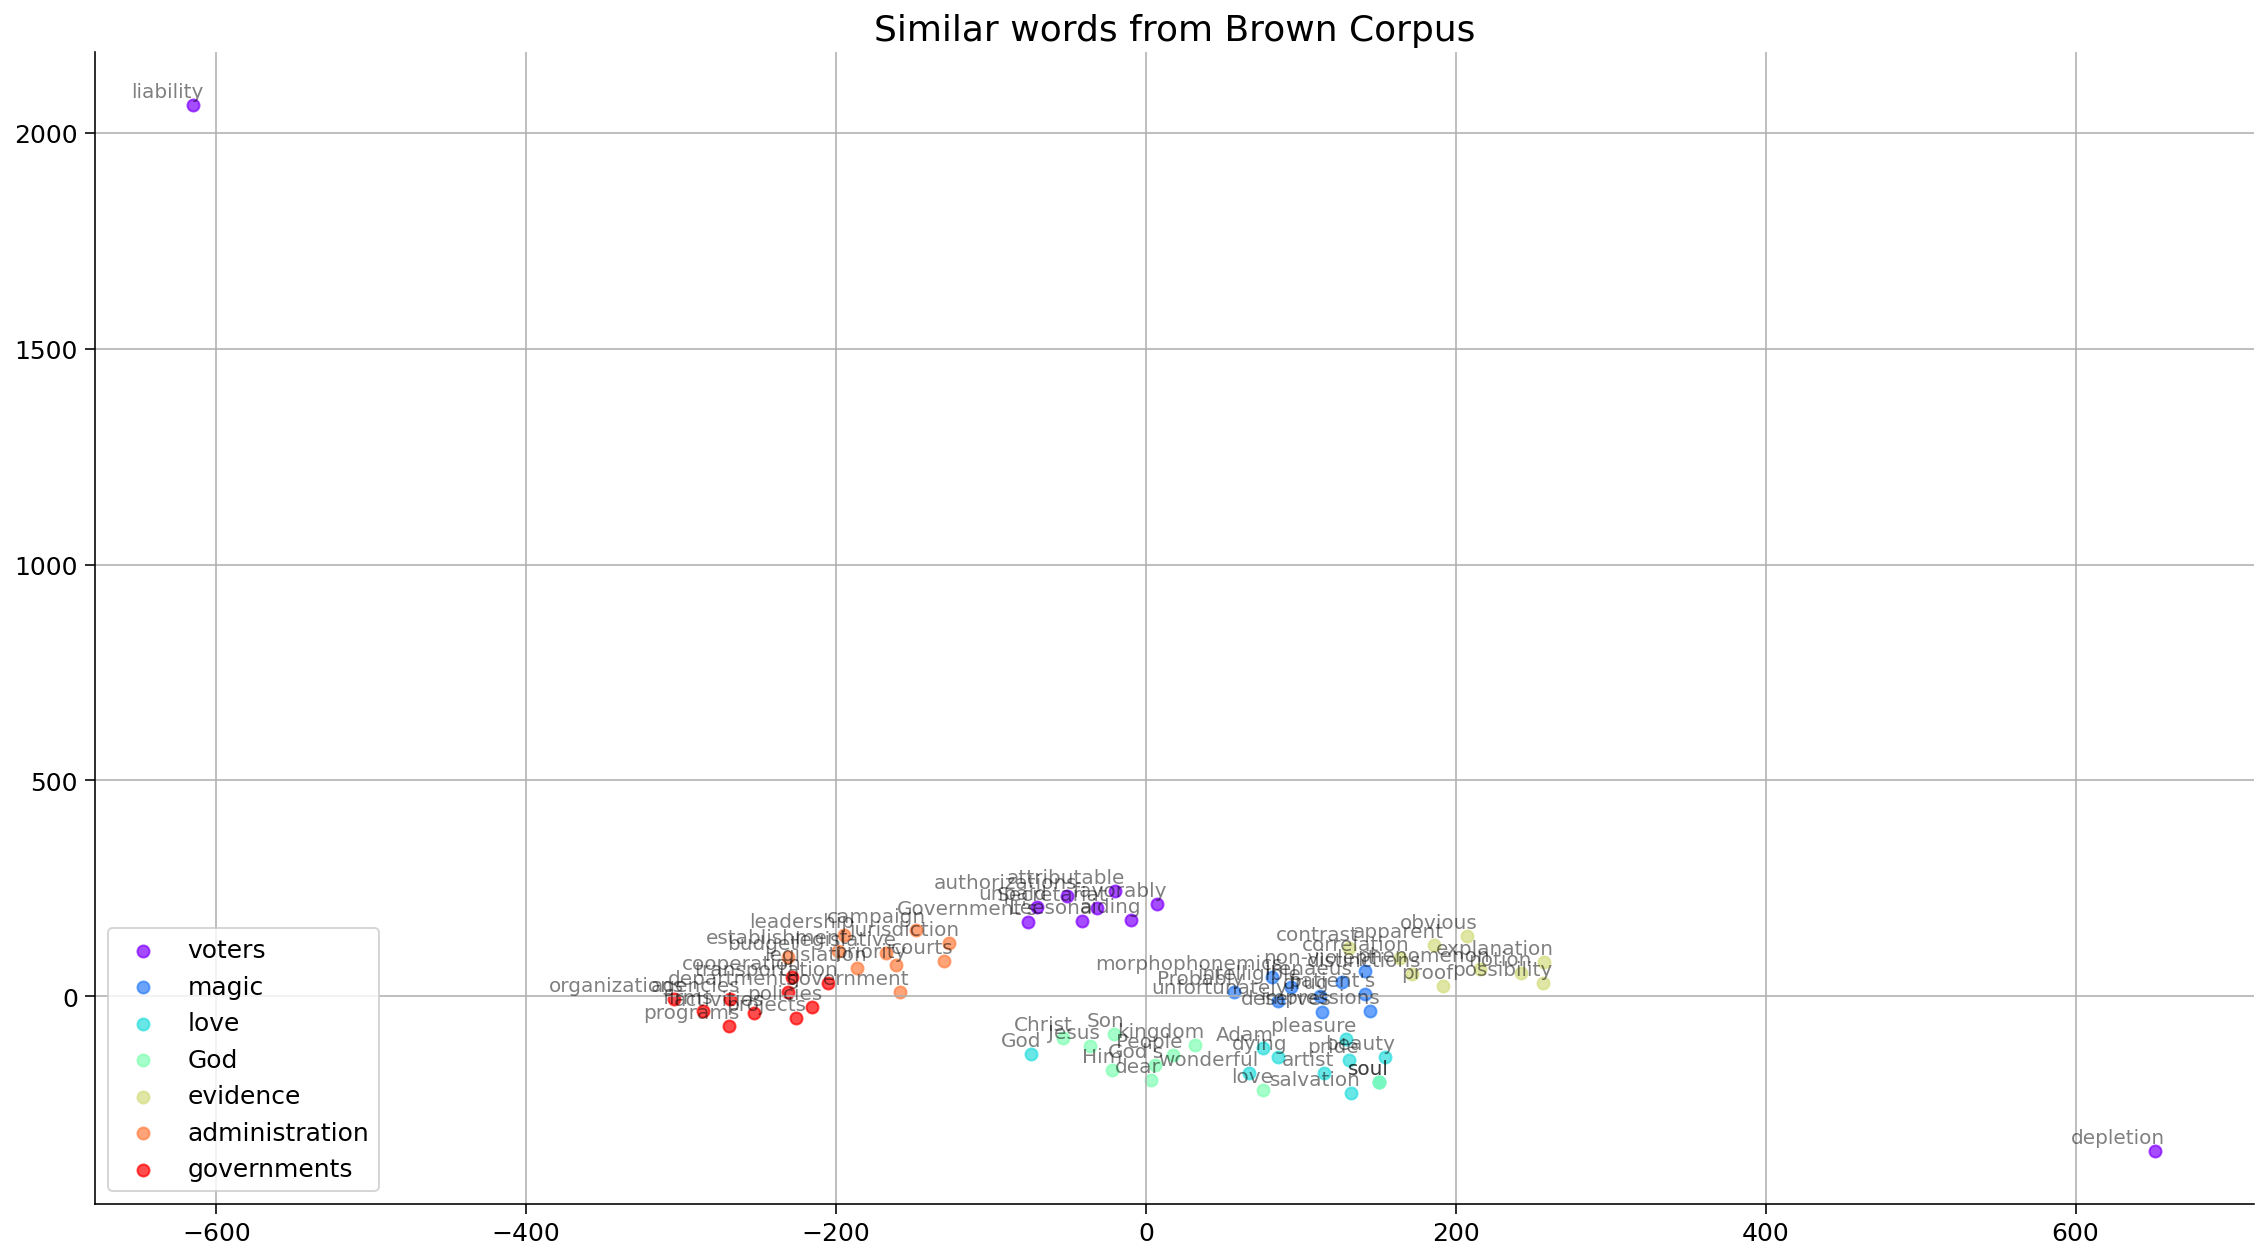

In [58]:
embeddings_en_2d, word_clusters = get_cluster_embeddings(keys)
tsne_plot_similar_words('Similar words from Brown Corpus', keys, embeddings_en_2d, word_clusters, 0.7)

## Section 2.3: Exploring meaning with word embeddings

While word2vec was the method that started it all, research has since boomed, and we now have more sophisticated ways to represent words. One such method is FastText, developed at Facebook AI research, which breaks words into sub-words: such a technique also allows us to create embedding representations for unseen words. In this section, we will explore how semantics and meaning are captured using embedidngs, after downloading a pre-trained FastText model. Downloading pre-trained models is a way for us to plug in word embeddings and explore them without training them ourselves.

In [59]:
# @title Download FastText English Embeddings of Dimension 100
import os, io, zipfile
from urllib.request import urlopen

zipurl = 'https://osf.io/w9sr7/download'
print(f"Downloading and unzipping the file... Please wait.")
with urlopen(zipurl) as zipresp:
  with zipfile.ZipFile(io.BytesIO(zipresp.read())) as zfile:
    zfile.extractall('.')
print("Download completed!")

Download completed!


In [60]:
# Load 100 dimension FastText Vectors using FastText library
ft_en_vectors = fasttext.load_model('cc.en.100.bin')

In [61]:
print(f"Length of the embedding is: {len(ft_en_vectors.get_word_vector('king'))}")
print(f"Embedding for the word King is: {ft_en_vectors.get_word_vector('king')}")

Length of the embedding is: 100
Embedding for the word King is: [-0.04045481 -0.10617249 -0.27222311  0.06879666  0.16408321  0.00276707
  0.27080125 -0.05805573 -0.31865698  0.03748008 -0.00254088  0.13805169
 -0.00182498 -0.08973497  0.00319015 -0.19619396 -0.09858181 -0.10103802
 -0.08279888  0.0082208   0.13119364 -0.15956607  0.17203182  0.0315701
 -0.25064597  0.06182072  0.03929246  0.05157393  0.03543638  0.13660161
  0.05473648  0.06072914 -0.04709269  0.17394426 -0.02101276 -0.11402624
 -0.24489872 -0.08576579 -0.00322696 -0.04509873 -0.00614253 -0.05772085
 -0.073414   -0.06718913 -0.06057961  0.10963406  0.1245006  -0.04819863
  0.11408057  0.11081408  0.06752145 -0.01689911 -0.01186301 -0.11716368
 -0.01287614  0.10639337 -0.04243141  0.01057278 -0.0230855  -0.04930984
  0.04717607  0.03696446  0.0015999  -0.02193867 -0.01331578  0.11102925
  0.1686794   0.05814958 -0.00296521 -0.04252011 -0.00352389  0.06267346
 -0.07747819 -0.08959802 -0.02445797 -0.08913022  0.13422231 

Cosine similarity is used for similarities between words. Similarity is a scalar between 0 and 1.

Now find the 10 most similar words to "King".

In [62]:
ft_en_vectors.get_nearest_neighbors("king", 10)  # Most similar by key

[(0.8168574571609497, 'prince'),
 (0.796097457408905, 'emperor'),
 (0.7907207608222961, 'kings'),
 (0.7655220627784729, 'lord'),
 (0.7435404062271118, 'king-'),
 (0.7394551634788513, 'chieftain'),
 (0.7307553291320801, 'tyrant'),
 (0.7226710319519043, 'conqueror'),
 (0.719561755657196, 'kingly'),
 (0.718187689781189, 'queen')]

### Word Similarity

In [63]:
# @title Video 3: Semantic Measurements
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV15w411R7SW", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"Y45KIAOw4OY", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# Add event to airtable
atform.add_event('Video 3: Semantic Measurements')

display(out)

More on similarity between words. Let's check how similar different pairs of word are. Feel free to play around.



In [64]:
def getSimilarity(word1, word2):
  """
  Defines similarity between set of words

  Args:  
    word1: string
      Word 1
    word2: string
      Word 2

  Returns: 
    Cosine similarity between word1 vector and word2 vector
  """
  v1 = ft_en_vectors.get_word_vector(word1)
  v2 = ft_en_vectors.get_word_vector(word2)
  return cosine_similarity(v1, v2)

print("Similarity between the words King and Queen: ", getSimilarity("king", "queen"))
print("Similarity between the words King and Knight: ", getSimilarity("king", "knight"))
print("Similarity between the words King and Rock: ", getSimilarity("king", "rock"))
print("Similarity between the words King and Twenty: ", getSimilarity("king", "twenty"))

## Try the same for two more pairs
# print("Similarity between the words ___ and ___: ", getSimilarity(...))
# print("Similarity between the words ___ and ___: ", getSimilarity(...))

# print("Similarity between the words ___ and ___: ", getSimilarity(...))
# print("Similarity between the words ___ and ___: ", getSimilarity(...))

Similarity between the words King and Queen:  0.71818775
Similarity between the words King and Knight:  0.6881009
Similarity between the words King and Rock:  0.28928387
Similarity between the words King and Twenty:  0.19655468


### Homonym Words$^\dagger$

Find the similarity for homonym words with their different meanings. The first one has been implemented for you.

$^\dagger$: Two or more words having the same spelling or pronunciation but different meanings and origins are called *homonyms*. E.g.,

In [65]:
#######################     Words with multiple meanings     ##########################
print("Similarity between the words Cricket and Insect: ", getSimilarity("cricket", "insect"))
print("Similarity between the words Cricket and Sport: ", getSimilarity("cricket", "sport"))

## Try the same for two more pairs
# print("Similarity between the words ___ and ___: ", getSimilarity(...))
# print("Similarity between the words ___ and ___: ", getSimilarity(...))

# print("Similarity between the words ___ and ___: ", getSimilarity(...))
# print("Similarity between the words ___ and ___: ", getSimilarity(...))

Similarity between the words Cricket and Insect:  0.40722153
Similarity between the words Cricket and Sport:  0.58123744


### Word Analogies

Embeddings can be used to find word analogies.
Let's try it:
1. Man : Woman  ::  King : _____
2. Germany: Berlin :: France : ______
3. Leaf : Tree  ::  Petal : _____
4. Hammer : Nail  ::  Comb : _____

In [66]:
## Use get_analogies() funnction. The words have to be in the order Positive, Negative, Positve

# Man : Woman  ::  King : _____
# Positive=(woman, king), Negative=(man)
print(ft_en_vectors.get_analogies("woman", "man", "king",1))

# Germany: Berlin :: France : ______
# Positive=(berlin, frannce), Negative=(germany)
print(ft_en_vectors.get_analogies("berlin", "germany", "france",1))

# Leaf : Tree  ::  Petal : _____
# Positive=(tree, petal), Negative=(leaf)
print(ft_en_vectors.get_analogies("tree", "leaf", "petal",1))

# Hammer : Nail  ::  Comb : _____
# Positive=(nail, comb), Negative=(hammer)
print(ft_en_vectors.get_analogies("nail", "hammer", "comb",1))

[(0.8162637948989868, 'queen')]
[(0.8568049669265747, 'paris')]
[(0.7037209272384644, 'flower')]
[(0.6908746361732483, 'hair')]


But, does it always work?


1.   Poverty : Wealth  :: Sickness : _____
2.   train : board :: horse : _____

In [67]:
# Poverty : Wealth  :: Sickness : _____
print(ft_en_vectors.get_analogies("wealth", "poverty", "sickness",1))

# train : board :: horse : _____
print(ft_en_vectors.get_analogies("train", "board", "horse",1))

[(0.615874171257019, 'affliction')]
[(0.6799090504646301, 'horses')]


---
# Section 3: Neural Net with word embeddings

*Time estimate: ~16mins*

Let's use the pretrained FastText embeddings to train a neural network on the IMDB dataset. 

To recap, the data consists of reviews and sentiments attached to it. It is a binary classification task. As a simple preview of the upcoming neural networks, we are going to introduce neural net with word embeddings. We'll see detailed networks in the next tutorial.




## Coding Exercise 3.1: Simple Feed Forward Net

This will load 300 dim FastText embeddings. It will take around 2-3 minutes.

Define a vanilla neural network with linear layers. Then average the word embeddings to get an embedding for the entire review.
The neural net will have one hidden layer of size 128.

In [68]:
# @title Download embeddings and clear old variables to clean memory.
# @markdown #### Execute this cell!
if 'ft_en_vectors' in locals():
  del ft_en_vectors
if 'w2vmodel' in locals():
  del w2vmodel

embedding_fasttext = FastText('simple')

.vector_cache/wiki.simple.vec: 293MB [00:16, 17.8MB/s]                           
100%|██████████| 111051/111051 [00:13<00:00, 8108.74it/s]


In [69]:
# @markdown Load the Dataset
TEXT, vocab_size, train_iter, valid_iter, test_iter = load_dataset(embedding_fasttext, seed=SEED)

downloading aclImdb_v1.tar.gz


100%|██████████| 84.1M/84.1M [00:06<00:00, 12.4MB/s]


Data are loaded. sentence length: 50 seed: 2021


In [70]:
class NeuralNet(nn.Module):
  """
  Neural Network with following structure: 
  nn.Embedding(vocab_size, embedding_length) 
  + nn.Parameter(word_embeddings, requires_grad=False) # Embedding Layer
  nn.Linear(embedding_length, hidden_size) # Fully connected layer #1
  nn.Linear(hidden_size, output_size) # Fully connected layer #2
  """

  def __init__(self, output_size, hidden_size, vocab_size, embedding_length,
               word_embeddings):
    """
    Initialize parameters of NeuralNet

    Args: 
      output_size: int
        Size of final fully connected layer
      hidden_size: int
        Size of hidden/first fully connected layer
      vocab_size: int
        Size of vocabulary
      embedding_length: int
        Length of embedding
      word_embeddings: TEXT.vocab.vectors instance
        Word Embeddings

    Returns: 
      Nothing
    """
    super(NeuralNet, self).__init__()

    self.word_embeddings = nn.Embedding(vocab_size, embedding_length)
    self.word_embeddings.weight = nn.Parameter(word_embeddings,
                                               requires_grad=False)
    self.fc1 = nn.Linear(embedding_length, hidden_size)
    self.fc2 = nn.Linear(hidden_size, output_size)


  def forward(self, inputs):
    """
    Forward pass of NeuralNet

    Args: 
      Inputs: list
        Text
    
    Returns:
      output: torch.tensor
        Outputs/Predictions
    """
    input = self.word_embeddings(inputs)  # Convert text to embeddings
    ####################################################################
    # Fill in missing code below (...)
    raise NotImplementedError("Fill in the Neural Net")
    ####################################################################
    # Average the word embeddings in a sentence
    # Use torch.nn.functional.avg_pool2d to compute the averages
    pooled = ...

    # Pass the embeddings through the neural net
    # A fully-connected layer
    x = ...
    # ReLU activation
    x = ...
    # Another fully-connected layer
    x = ...
    output = F.log_softmax(x, dim=1)

    return output


# Add event to airtable
atform.add_event('Coding Exercise 3.1: Simple Feed Forward Net')

# Uncomment to check your code
# nn_model = NeuralNet(2, 128, 100, 300, TEXT.vocab.vectors)
# print(nn_model)

In [71]:
# to_remove solution
class NeuralNet(nn.Module):
  """
  Neural Network with following structure: 
  nn.Embedding(vocab_size, embedding_length) 
  + nn.Parameter(word_embeddings, requires_grad=False) # Embedding Layer
  nn.Linear(embedding_length, hidden_size) # Fully connected layer #1
  nn.Linear(hidden_size, output_size) # Fully connected layer #2
  """

  def __init__(self, output_size, hidden_size, vocab_size, embedding_length,
               word_embeddings):
    """
    Initialize parameters of NeuralNet

    Args: 
      output_size: int
        Size of final fully connected layer
      hidden_size: int
        Size of hidden/first fully connected layer
      vocab_size: int
        Size of vocabulary
      embedding_length: int
        Length of embedding
      word_embeddings: TEXT.vocab.vectors instance
        Word Embeddings

    Returns: 
      Nothing
    """
    super(NeuralNet, self).__init__()

    self.word_embeddings = nn.Embedding(vocab_size, embedding_length)
    self.word_embeddings.weight = nn.Parameter(word_embeddings,
                                               requires_grad=False)
    self.fc1 = nn.Linear(embedding_length, hidden_size)
    self.fc2 = nn.Linear(hidden_size, output_size)


  def forward(self, inputs):
    """
    Forward pass of NeuralNet

    Args: 
      Inputs: list
        Text
    
    Returns:
      output: torch.tensor
        Outputs/Predictions
    """
    input = self.word_embeddings(inputs)  # Convert text to embeddings
    # Average the word embeddings in a sentence
    # Use torch.nn.functional.avg_pool2d to compute the averages
    pooled = F.avg_pool2d(input, (input.shape[1], 1)).squeeze(1)

    # Pass the embeddings through the neural net
    # A fully-connected layer
    x = self.fc1(pooled)

    # ReLU activation
    x = F.relu(x)
    # Another fully-connected layer
    x = self.fc2(x)
    output = F.log_softmax(x, dim=1)

    return output


# Add event to airtable
atform.add_event('Coding Exercise 3.1: Simple Feed Forward Net')

# Uncomment to check your code
nn_model = NeuralNet(2, 128, 100, 300, TEXT.vocab.vectors)
print(nn_model)

NeuralNet(
  (word_embeddings): Embedding(100, 300)
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


```
NeuralNet(
  (word_embeddings): Embedding(100, 300)
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)
```

In [72]:
# @title Training and Testing Functions

# @markdown #### `train(model, device, train_iter, valid_iter, epochs, learning_rate)`
# @markdown #### `test(model, device, test_iter)`

def train(model, device, train_iter, valid_iter, 
          epochs, learning_rate):
  """
  Training pass

  Args:
    model: nn.module
      NeuralNet instance
    device: string
      GPU if available, CPU otherwise
    epochs: int
      Number of epochs to train model for
    learning_rate: float
      Learning rate
    train_iter: BucketIterator
      Training iterator
    valid_iter: BucketIterator
      Validation iterator

  Returns:
    train_loss: list
      Log of training loss
    validation_loss: list
      Log of validation loss
    train_acc: list
      Log of training accuracy
    validation_acc: list
      Log of validation accuracy
  """ 
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  train_loss, validation_loss = [], []
  train_acc, validation_acc = [], []

  for epoch in range(epochs):
    # train
    model.train()
    running_loss = 0.
    correct, total = 0, 0
    steps = 0

    for idx, batch in enumerate(train_iter):
      text = batch.text[0]
      target = batch.label
      target = torch.autograd.Variable(target).long()
      text, target = text.to(device), target.to(device)

      # Add micro for coding training loop
      optimizer.zero_grad()
      output = model(text)
      loss = criterion(output, target)
      loss.backward()
      optimizer.step()
      steps += 1
      running_loss += loss.item()

      # Get accuracy

      # To get predicted values for each row 
      # across the entire batch
      _, predicted = torch.max(output, 1)
      
      total += target.size(0)
      correct += (predicted == target).sum().item()
    train_loss.append(running_loss/len(train_iter))
    train_acc.append(correct/total)

    print(f'Epoch: {epoch + 1}, '
          f'Training Loss: {running_loss/len(train_iter):.4f}, '
          f'Training Accuracy: {100*correct/total: .2f}%')

    # Evaluate on validation data
    model.eval()
    running_loss = 0.
    correct, total = 0, 0

    with torch.no_grad():
      for idx, batch in enumerate(valid_iter):
        text = batch.text[0]
        target = batch.label
        target = torch.autograd.Variable(target).long()
        text, target = text.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(text)

        loss = criterion(output, target)
        running_loss += loss.item()

        # Get accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    validation_loss.append(running_loss/len(valid_iter))
    validation_acc.append(correct/total)

    print (f'Validation Loss: {running_loss/len(valid_iter):.4f}, '
           f'Validation Accuracy: {100*correct/total: .2f}%')

  return train_loss, train_acc, validation_loss, validation_acc


def test(model, device, test_iter):
  """
  Test loop

  Args: 
    model: nn.module
      NeuralNet instance
    device: string
      GPU if available, 
    test_iter: BucketIterator
      Test iterator

  Returns: 
    acc: float
      Test Accuracy
  """
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    for idx, batch in enumerate(test_iter):
      text = batch.text[0]
      target = batch.label
      target = torch.autograd.Variable(target).long()
      text, target = text.to(device), target.to(device)

      outputs = model(text)
      _, predicted = torch.max(outputs, 1)
      total += target.size(0)
      correct += (predicted == target).sum().item()

    acc = 100 * correct / total
    return acc

In [73]:
# Model hyperparameters
learning_rate = 0.0003
output_size = 2
hidden_size = 128
embedding_length = 300
epochs = 15
word_embeddings = TEXT.vocab.vectors
vocab_size = len(TEXT.vocab)

# Model set-up
nn_model = NeuralNet(output_size,
                     hidden_size,
                     vocab_size,
                     embedding_length,
                     word_embeddings)
nn_model.to(DEVICE)
nn_start_time = time.time()
set_seed(522)
nn_train_loss, nn_train_acc, nn_validation_loss, nn_validation_acc = train(nn_model,
                                                                           DEVICE,
                                                                           train_iter,
                                                                           valid_iter,
                                                                           epochs,
                                                                           learning_rate)
print(f"--- Time taken to train = {(time.time() - nn_start_time)} seconds ---")
test_accuracy = test(nn_model, DEVICE, test_iter)
print(f'\n\nTest Accuracy: {test_accuracy}%')

Random seed 522 has been set.
Epoch: 1, Training Loss: 0.6693, Training Accuracy:  59.90%
Validation Loss: 0.6433, Validation Accuracy:  64.39%
Epoch: 2, Training Loss: 0.6298, Training Accuracy:  65.11%
Validation Loss: 0.6125, Validation Accuracy:  67.84%
Epoch: 3, Training Loss: 0.6043, Training Accuracy:  68.04%
Validation Loss: 0.5965, Validation Accuracy:  68.48%
Epoch: 4, Training Loss: 0.5922, Training Accuracy:  68.79%
Validation Loss: 0.5877, Validation Accuracy:  69.20%
Epoch: 5, Training Loss: 0.5864, Training Accuracy:  68.86%
Validation Loss: 0.5901, Validation Accuracy:  68.75%
Epoch: 6, Training Loss: 0.5815, Training Accuracy:  69.50%
Validation Loss: 0.5802, Validation Accuracy:  69.48%
Epoch: 7, Training Loss: 0.5781, Training Accuracy:  69.93%
Validation Loss: 0.5791, Validation Accuracy:  69.67%
Epoch: 8, Training Loss: 0.5764, Training Accuracy:  69.89%
Validation Loss: 0.5943, Validation Accuracy:  68.21%
Epoch: 9, Training Loss: 0.5749, Training Accuracy:  69.87

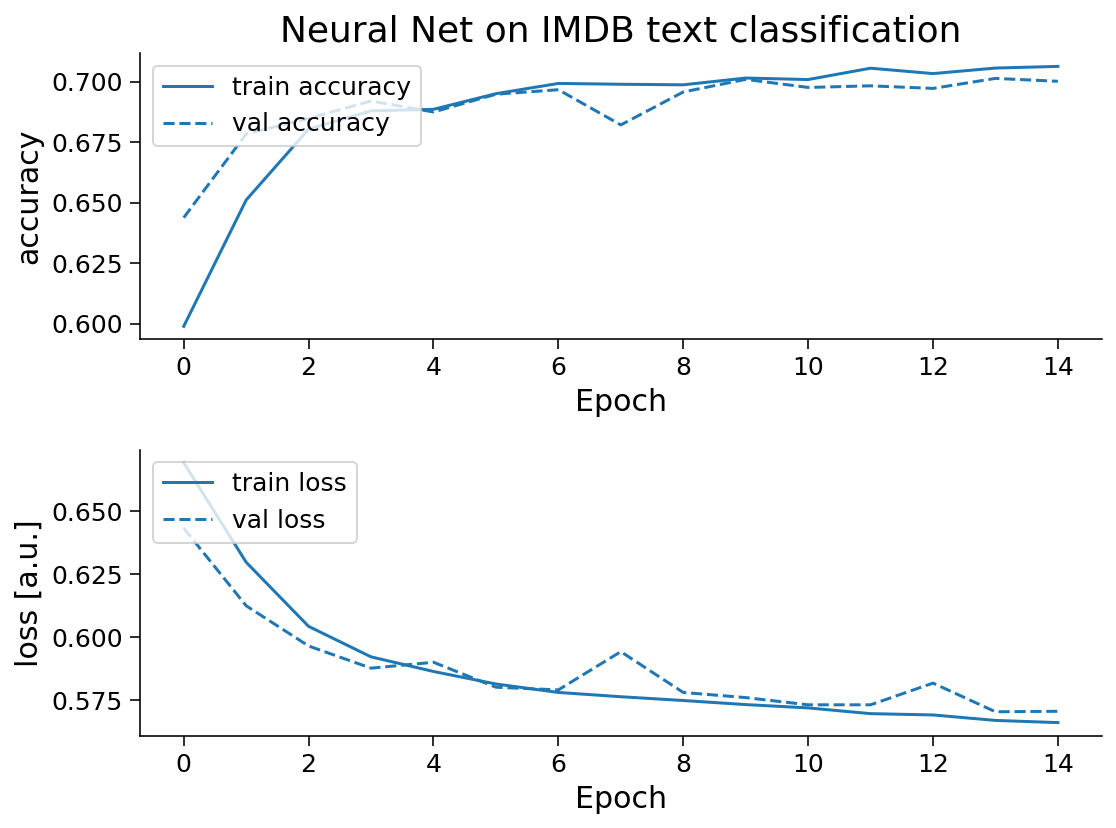

In [74]:
# Plot accuracy curves
plt.figure()
plt.subplot(211)
plot_train_val(np.arange(0, epochs), nn_train_acc, nn_validation_acc,
               'train accuracy', 'val accuracy',
               'Neural Net on IMDB text classification', 'accuracy',
               color='C0')
plt.legend(loc='upper left')
plt.subplot(212)
plot_train_val(np.arange(0, epochs), nn_train_loss,
               nn_validation_loss,
               'train loss', 'val loss',
               '',
               'loss [a.u.]',
               color='C0')
plt.legend(loc='upper left')
plt.show()

---
# Summary

In this tutorial, we explored two different concepts linked to sequences, and text in particular, that will be the conceptual foundation for Recurrent Neural Networks.

The first concept was that of sequences and probabilities. We saw how we can model language as sequences of text, and use this analogy to generate text. Such a setup is also used to classify text or identify parts of speech. We can either build chains manually using simple python and numerical computation, or use a package such as ```hmmlearn``` that allows us to train models a lot easier. These notions of sequences and probabilities (i.e, creating language models!) are key to the internals of a recurrent neural network as well. 

The second concept is that of word embeddings, now a mainstay of natural language processing. By using a neural network to predict context of words, these neural networks learn internal representions of words that are a decent approximation of semantic meaning (i.e embeddings!). We saw how these embeddings can be visualised, as well as how they capture meaning. We finally saw how they can be integrated into neural networks to better classify text documents.

In [75]:
# @title Airtable Submission Link
from IPython import display as IPydisplay
IPydisplay.HTML(
   f"""
 <div>
   <a href= "{atform.url()}" target="_blank">
   <img src="https://github.com/NeuromatchAcademy/course-content-dl/blob/main/tutorials/static/AirtableSubmissionButton.png?raw=1"
 alt="button link to Airtable" style="width:410px"></a>
   </div>""" )